# Instalação de pacotes

In [1]:
##pip install pyswarms ## Pacote PySwarm - otimização PSO (enxames)

# Import Bibliotecas

In [2]:
## Swarm (Enxame)
import pyswarms as ps    ## Enxame
from pyswarms.utils.plotters import plot_cost_history ## Plot curva convergência enxame

## Data manipulation
import pandas as pd
import numpy as np

## Datasets
import openml  ## biblioteca para importar datasets

## Processamento
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score ## Métricas (função objetivo)
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

## Modelo SVC
from sklearn.svm import SVC

2024-04-28 19:52:11,868 - numexpr.utils - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-04-28 19:52:11,869 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2024-04-28 19:52:12,461 - openml.config - INFO - Error opening file C:\Users\pichau\.openml\config: not readable


# Leitura dos dados

In [171]:
##data = openml.datasets.get_dataset(44)
data = openml.datasets.get_dataset(54)
X, y, categorical_indicator, attribute_names = data.get_data(
    dataset_format = "array", target=data.default_target_attribute
)

X = pd.DataFrame(X, columns = attribute_names)
y = pd.Series(y)
X

C:\Users\pichau\AppData\Local\Temp\ipykernel_5588\536945259.py:2: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  data = openml.datasets.get_dataset(54)
2024-04-28 21:24:40,761 - root - INFO - Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/54
2024-04-28 21:24:41,979 - root - INFO - 1.2162740s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/54
2024-04-28 21:24:41,982 - root - INFO - Starting [get] request for the URL https://www.openml.org/api/v1/xml/data/features/54
2024-04-28 21:24:42,931 - root - INFO - 0.9492135s taken for [get] request for the URL https://www.openml.org/api/v1/xml/data/features/54
2024-04-28 21:24:42,9

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO
0,95.0,48.0,83.0,178.0,72.0,10.0,162.0,42.0,20.0,159.0,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197.0
1,91.0,41.0,84.0,141.0,57.0,9.0,149.0,45.0,19.0,143.0,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199.0
2,104.0,50.0,106.0,209.0,66.0,10.0,207.0,32.0,23.0,158.0,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196.0
3,93.0,41.0,82.0,159.0,63.0,9.0,144.0,46.0,19.0,143.0,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207.0
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0


In [173]:
y.value_counts()

2    218
1    217
0    212
3    199
Name: count, dtype: int64

In [174]:
num_columns = X.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16']).columns
cat_columns = X.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]']).columns

In [175]:
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), ## Nem todo modelo consegue lidar com valores nulos, vamos automatizar o que fazer com os nulls (fill com mediana)
    ('scaler',StandardScaler())                    ## Nem todo modelo consegue lidar com a escala de todas as featues, vamos standardizá-las
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  ## Nem todo modelo consegue lidar com valores nulos, vamos automatizar o que fazer com os nulls (cat mais frequente)
    ('encoder', TargetEncoder())                           ## Para features categóricas vamos usar a informação conhecida do target para acelerar o aprendizado (tb transformando-os em numerico!)
])


preprocessor = ColumnTransformer([
    ('categorical', categorical_pipe, cat_columns),
    ('numeric', numeric_pipe, num_columns)
])

# Splitting treino / test

- Como SVM é um algorítmo pesado computacionalmente vamos limitar os dados de treino para apenas 500 datapoints.

In [176]:
seed = 42 ## Reprodutibilidade do modelo

In [177]:
test_size = (len(X)-500)/len(X)
if test_size < 0:
    test_size= 0.3 ## Padrão 30% para o teste caso não haja 500 datapoints disponíveis para alocar nos dados de treino

test_size

0.408983451536643

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y, shuffle=True)

In [179]:
y_train.value_counts(), y_test.value_counts()

(2    129
 1    128
 0    125
 3    118
 Name: count, dtype: int64,
 1    89
 2    89
 0    87
 3    81
 Name: count, dtype: int64)

# SETUP PSO: Aplicado á otimização do modelo de floresta aleatória.
- Vamos utilizar a inteligência de enxame (PSO) para encontrar os melhores hiperparâmetros num modelo SVM.
- Por questão de simplicidade e demonstração do PSO escolheremos apenas 2 hiperparâmetros a fim de visualizarmos o enxame num espaço 2D (R2).
- Escolhemos esse modelo, pois, os dois principais hiperparâmetros (C e gamma) são números contínuos (e não discretos), assim, conseguimos extrair o máximo potencial do PSO frente á outros métodos de tunning de hiperparâmetros discretos (como bayesiano - optuna ou por grid, por ex)

### Espaço de hiperparâmetros:
- C: (0.01,100)
- gamma: (0.01,100)

### Função Objetivo
Nossa função objetivo será a média da acurácia obtida em validação cruzada com 5 folds.




### Função posição das partículas
A posição nada mais é que o conjunto de hiperparâmetros [C, gamma]

A função da posição de cada particula é representada por:  
xi(t+1)=xi(t)+vi(t+1)


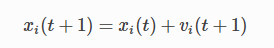

In [180]:
from IPython import display
display.Image("./images/eq_posicao.png")

### Função velocidade das partículas
Onde a velocidade é:  
vij(t+1)= w∗vij(t)  +  c1r1j(t)[yij(t)−xij(t)]  +  c2r2j(t)[y^j(t)−xij(t)]


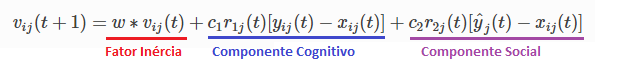

In [181]:
from IPython import display
display.Image("./images/eq_velocidade.png")


### Parâmetros da velocidade das partículas
w:  parâmetro que define o grau de inércia da partícula sobre o deslocamento da partícula. (Inércia)  
c1: parâmetro que define o quanto seu próprio histórico de explorar o espaço na busca pela melhor posição influencia no seu próprio deslocamento.  (Componente cognitivo)  
c2: parâmetro que define o quanto a melhor posição do enxame como um todo influência no seu próprio deslocamento.  (Componente social)  

r1 e r2: geradas aleatoriamente a cada iteração para permitir que o enxame explore mais o espaço e evitar que fique estacionado em algum mínimo local.

In [182]:
## Especificando o espaço R2 varrido [C, gamma]
espaco = (np.array([0.01, 0.01]), np.array([100, 100]))
print(espaco)

(array([0.01, 0.01]), array([100, 100]))


In [183]:
## Inicialização da variável para armazenar a posição das partículas
from collections import defaultdict 
results_dict = defaultdict(list)
results_dict

defaultdict(list, {})

In [184]:
## Inicialização das variáveis de inércia, componente cognitivo e componente social
vars_velocidade = {'w':0.7, 'c1': 0.4, 'c2': 0.4}

In [185]:
## Função objetivo (fitness):
# customized fitness_function 
def fitness_function(posicoes, X_train, y_train, results_dict, seed):

  ## posicoes = array com todos [C,gamma] da partícula
  ## X_train = dados de treino
  ## y_train = rótulo dos dados de treino
  ## resultados = variável criada anteriormente para armazenar as posições de todas as particulas e as suas movimentações em cada iteraçao
  ## seed = variável para reprodutibilidade do experimento

  #print(candidates)
  acc_scores = []
  for pos in posicoes:
   
    #print(pos)
    C = pos[0]
    gamma = pos[1]

    model = SVC(random_state=seed)
    model.set_params(**{'C': C, 'gamma': gamma})
 
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    scores = cross_val_score(pipe, X=X_train, y = y_train, cv=5)
    accuracy = scores.mean()
    acc_scores.append(accuracy)
    
    # saving results    
    results_dict['seed'].append(seed)
    results_dict['C'].append(C)
    results_dict['gamma'].append(gamma)
    results_dict['accuracy'].append(accuracy)

  
  ## Como por padrão a biblioteca pyswarms retorna um min() como função objetivo, vamos usar de return da função fitness a acurácia * (-1) para encontrar o mínimo
  return_accuracy_scores = -np.array(acc_scores)

  return return_accuracy_scores

# Criando e simulando nosso enxame - PSO

In [186]:
# Qtd de partículas do enxame e numero de iterações (movimentos)
n_particles = 15 ## 15 particulas se movimentando
iters       = 80 ## 80 movimentos de cada partícula

In [187]:
## Instanciando o PSO
optimizer = ps.single.GlobalBestPSO(
     n_particles = n_particles, 
     dimensions  = 2,                  #  dimensoes do problema (2 = dois hiperparâmetros, espaço R2)
     bounds      = espaco,
     options     = vars_velocidade
)

In [188]:
# Running PSO
stats = optimizer.optimize(
    fitness_function,             # funcao objetivo
    iters = iters,                # iterações
    X_train = X_train,            # dados treino
    y_train = y_train,            # rótulos treino
    results_dict = results_dict,    # variável para salvar posição de todas as partículas em cada iteração
    seed = seed                   # seed reprodutibilidade do experimento
)                  


2024-04-28 21:25:11,957 - pyswarms.single.global_best - INFO - Optimize for 80 iters with {'w': 0.7, 'c1': 0.4, 'c2': 0.4}
pyswarms.single.global_best: 100%|██████████|80/80, best_cost=-.814
2024-04-28 21:27:35,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8140000000000001, best pos: [25.25920424  0.06793844]


# Avaliação dos resultados

In [189]:
## Melhor acurácia obtida
best_accuracy = -1 * stats[0]
best_accuracy

0.8140000000000001

In [190]:
## Melhor hiperparâmetro onde ocorreu a melhor acurácia (posição da melhor particula).
melhor_posicao = stats[1]
melhor_posicao

array([25.25920424,  0.06793844])

In [191]:
melhor_C = melhor_posicao[0]
melhor_gamma = melhor_posicao[1]
print(f"Melhor conjunto de hiperparâmetros C = {melhor_C} e gamma = {melhor_gamma}")

Melhor conjunto de hiperparâmetros C = 25.25920423888918 e gamma = 0.06793844173847674


<Axes: title={'center': 'Cost History'}, xlabel='Iterations', ylabel='Cost'>

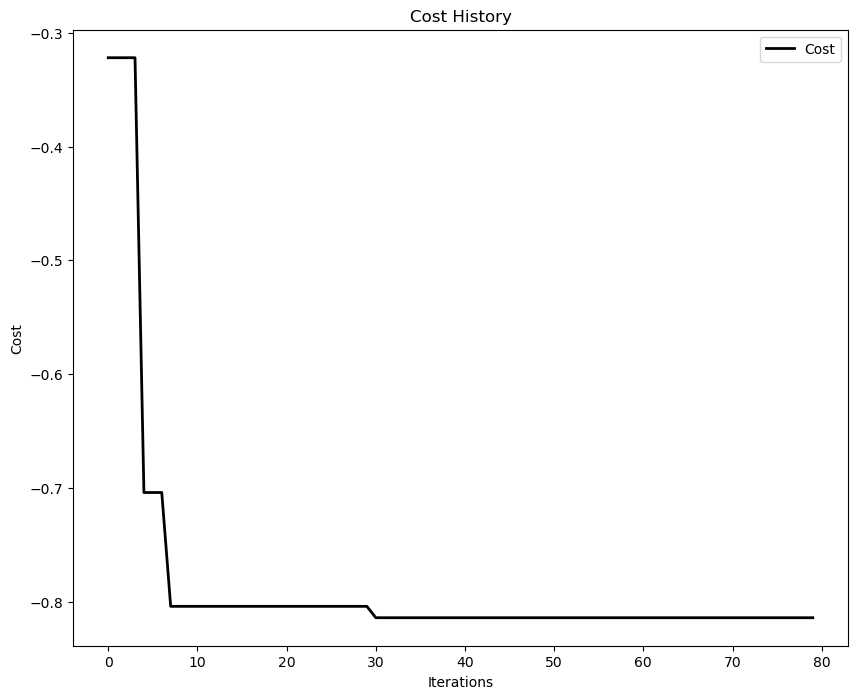

In [192]:
plot_cost_history(optimizer.cost_history)

- Já observamos a melhor acurácia por volta da 30ª iteração!

# Avaliação posição particulas em cada iteração

In [193]:
## Recuperando posicoes
df_posicoes = pd.DataFrame(results_dict)

## Identificando as partículas
df_posicoes = df_posicoes.reset_index(names = 'particle')
df_posicoes['particle'] = df_posicoes['particle'].apply(lambda x: x % (n_particles))
df_posicoes['particle'] = df_posicoes['particle'] + 1
df_posicoes

## Identificando as iteracoes
df_posicoes = df_posicoes.reset_index(names = 'iteracao')
df_posicoes['iteracao'] = df_posicoes['iteracao'] + 1
df_posicoes['iteracao'] = df_posicoes['iteracao'].apply(lambda x: np.ceil(x/n_particles))
df_posicoes

,iteracao,particle,seed,C,gamma,accuracy
0,1.0,1,42,83.255605,97.898615,0.256
1,1.0,2,42,12.880439,60.727407,0.260
2,1.0,3,42,92.409233,39.512635,0.260
3,1.0,4,42,29.366673,68.610935,0.258
4,1.0,5,42,50.304413,94.587889,0.256
...,...,...,...,...,...,...
1195,80.0,11,42,27.838106,88.823720,0.256
1196,80.0,12,42,37.034702,96.197807,0.256
1197,80.0,13,42,25.258624,89.984153,0.256
1198,80.0,14,42,17.580330,62.356051,0.260


In [194]:
df_posicoes[df_posicoes['accuracy']==best_accuracy]

,iteracao,particle,seed,C,gamma,accuracy
462,31.0,13,42,25.259204,0.067938,0.814


- A melhor acurácia observada foi obtida pela partícula 13 na sua 31ª iteração

In [209]:
df_pos_inicial = df_posicoes[df_posicoes['iteracao']==1]
df_pos_final = df_posicoes[df_posicoes['iteracao']==31] ## Após a 31º iteração o enxame continua explorando o espaço mas essa é a iteração que retornou o melhor resultado individual de uma particula

In [210]:
df_pos_final

,iteracao,particle,seed,C,gamma,accuracy
450,31.0,1,42,29.666024,62.975416,0.260
451,31.0,2,42,26.422780,1.048868,0.632
452,31.0,3,42,16.687992,23.095302,0.264
453,31.0,4,42,24.191843,29.523959,0.260
454,31.0,5,42,23.769208,32.428171,0.260
455,31.0,6,42,25.819998,7.782859,0.280
456,31.0,7,42,23.131898,76.026267,0.256
457,31.0,8,42,29.454236,73.323824,0.256
458,31.0,9,42,19.853254,95.242424,0.256
459,31.0,10,42,24.904267,82.277966,0.256


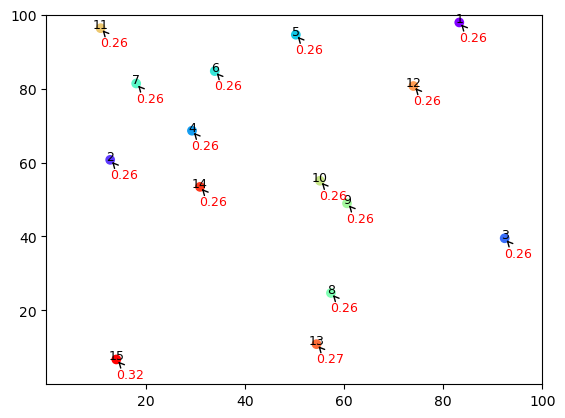

In [196]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Define o número de pontos
num_pontos = n_particles

# Cria as posições iniciais e finais para os pontos
x_inicial = df_pos_inicial['C'].values
y_inicial = df_pos_inicial['gamma'].values

x_final = df_pos_final['C'].values
y_final = df_pos_final['gamma'].values

# Define cores para cada ponto
colors = plt.cm.rainbow(np.linspace(0, 1, num_pontos))

# Gera valores aleatórios para as flechas
flechas_iniciais = df_pos_inicial.accuracy.values
flechas_finais = df_pos_final.accuracy.values

# Cria a figura e o eixo
fig, ax = plt.subplots()

# Define os limites do gráfico para garantir que todos os pontos sejam visíveis
ax.set_xlim(0.01, 100)
ax.set_ylim(0.01, 100)

# Cria o scatter plot para a animação
scatter = ax.scatter(x_inicial, y_inicial, c=colors)

# Rótulos para cada ponto
labels = [ax.text(x, y, str(i + 1), fontsize=9, ha='center') for i, (x, y) in enumerate(zip(x_inicial, y_inicial))]

# Adiciona flechas para os pontos iniciais
flechas_iniciais_annot = [
    ax.annotate(
        f"{flechas_iniciais[i]:.2f}",
        xy=(x_inicial[i], y_inicial[i]),
        xytext=(x_inicial[i] - 0.1, y_inicial[i] - 5),  # Aproximação do texto para encurtar a flecha
        textcoords="data",
        arrowprops=dict(arrowstyle="->", color="black"),
        fontsize=9,
        color="red",
    )
    for i in range(num_pontos)
]

# Número de quadros para a animação
num_frames = 100

# Função para atualizar a posição dos pontos e das anotações em cada quadro
def update(frame):
    # Interpolação linear entre posições iniciais e finais
    x_interpolated = x_inicial + frame * (x_final - x_inicial) / num_frames
    y_interpolated = y_inicial + frame * (y_final - y_inicial) / num_frames
    
    scatter.set_offsets(np.column_stack((x_interpolated, y_interpolated)))
    
    # Atualiza a posição dos rótulos
    for label, x, y in zip(labels, x_interpolated, y_interpolated):
        label.set_position((x, y))
    
    # Controla as flechas para mostrar apenas no início e no final
    if frame == 0:
        for flecha in flechas_iniciais_annot:
            flecha.set_visible(True)
    elif frame == num_frames - 1:

        # No final, atualiza as flechas com valores de acuracia
        flechas_finais_annot = [
            ax.annotate(
                f"{flechas_finais[i]:.2f}",
                xy=(x_interpolated[i], y_interpolated[i]),
                xytext=(x_interpolated[i] - 0.1, y_interpolated[i] - 5),  # Menos cumprido
                textcoords="data",
                arrowprops=dict(arrowstyle="->", color="black"),
                fontsize=9,
                color="red",
            )
            for i in range(num_pontos)
        ]
        return scatter, *labels, *flechas_finais_annot
    else:

        # No meio da animação, tornamos as flechas invisíveis
        for flecha in flechas_iniciais_annot:
            flecha.set_visible(False)
    
    return scatter, *labels

# Cria a animação
anim = animation.FuncAnimation(
    fig, update, frames=num_frames, blit=True, interval=50, repeat=False
)

# Exibe a animação
plt.show()

In [197]:
## anim.save("./images/animação.gif", writer="imagemagick")

## Força bruta: avaliando acurácia no espaço vetorial definido
- Vamos mapear os resultados da acuracia por meio da força bruta e comparar a convergência da otimização por enxame de particulas nesse espaço.  
- C em [0.01,100]  
- gamma em [0.01,100]  

In [198]:
espaco_C = np.arange(0.01, 100, 1, dtype=float)
espaco_gamma = np.arange(0.01, 100, 1, dtype=float)

## Adicionando o melhor ponto encontrado pelo PSO
espaco_C = np.append(espaco_C, melhor_C, axis=None)
espaco_C = np.sort(espaco_C, axis=-1, kind=None, order=None)

espaco_gamma = np.append(espaco_gamma, melhor_gamma, axis=None)
espaco_gamma = np.sort(espaco_gamma, axis=-1, kind=None, order=None)

In [199]:
seed = 42
df_acuracia_espaco = pd.DataFrame()

num_it = 1
total_iteracoes = len(espaco_C) * len(espaco_gamma)

for C in espaco_C:
    for gamma in espaco_gamma:
    

        model = SVC(random_state=seed)
        model.set_params(**{'C': C, 'gamma': gamma})

        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        scores = cross_val_score(pipe, X=X_train, y = y_train, cv=5)
        accuracy = scores.mean()
        
        ## Armazenando dados do espaço percorrido
        df_iteradao = pd.DataFrame(np.array([[C,gamma,accuracy]]), columns = ['C','gamma','accuracy'])
        df_acuracia_espaco = pd.concat([df_acuracia_espaco, df_iteradao])

        
        ##report status:
        num_it = num_it + 1
        if num_it%100==0:
            print(f'iteracao {num_it} finalizada - {round(100*num_it/total_iteracoes,2)}%')


iteracao 100 finalizada - 0.98%
iteracao 200 finalizada - 1.96%
iteracao 300 finalizada - 2.94%
iteracao 400 finalizada - 3.92%
iteracao 500 finalizada - 4.9%
iteracao 600 finalizada - 5.88%
iteracao 700 finalizada - 6.86%
iteracao 800 finalizada - 7.84%
iteracao 900 finalizada - 8.82%
iteracao 1000 finalizada - 9.8%
iteracao 1100 finalizada - 10.78%
iteracao 1200 finalizada - 11.76%
iteracao 1300 finalizada - 12.74%
iteracao 1400 finalizada - 13.72%
iteracao 1500 finalizada - 14.7%
iteracao 1600 finalizada - 15.68%
iteracao 1700 finalizada - 16.67%
iteracao 1800 finalizada - 17.65%
iteracao 1900 finalizada - 18.63%
iteracao 2000 finalizada - 19.61%
iteracao 2100 finalizada - 20.59%
iteracao 2200 finalizada - 21.57%
iteracao 2300 finalizada - 22.55%
iteracao 2400 finalizada - 23.53%
iteracao 2500 finalizada - 24.51%
iteracao 2600 finalizada - 25.49%
iteracao 2700 finalizada - 26.47%
iteracao 2800 finalizada - 27.45%
iteracao 2900 finalizada - 28.43%
iteracao 3000 finalizada - 29.41%
it

In [204]:
df_acuracia_espaco[(df_acuracia_espaco['C']==melhor_C) & (df_acuracia_espaco['gamma']==melhor_gamma)]

,C,gamma,accuracy
0,25.259204,0.067938,0.814


In [205]:
densidade_acuracia = df_acuracia_espaco.pivot(columns='C', index='gamma', values = 'accuracy')
densidade_acuracia

C,0.01,1.01,2.01,3.01,4.01,5.01,6.01,7.01,8.01,9.01,...,90.01,91.01,92.01,93.01,94.01,95.01,96.01,97.01,98.01,99.01
gamma,,,,,,,,,,,,,,,,,,,,,
0.010000,0.298,0.712,0.732,0.736,0.758,0.762,0.760,0.774,0.772,0.770,...,0.824,0.824,0.824,0.824,0.824,0.824,0.824,0.824,0.824,0.824
0.067938,0.306,0.766,0.778,0.782,0.792,0.800,0.814,0.810,0.816,0.822,...,0.818,0.818,0.818,0.818,0.818,0.818,0.818,0.818,0.818,0.818
1.010000,0.288,0.636,0.640,0.638,0.636,0.636,0.636,0.636,0.636,0.636,...,0.636,0.636,0.636,0.636,0.636,0.636,0.636,0.636,0.636,0.636
2.010000,0.276,0.524,0.546,0.546,0.546,0.546,0.546,0.546,0.546,0.546,...,0.546,0.546,0.546,0.546,0.546,0.546,0.546,0.546,0.546,0.546
3.010000,0.264,0.400,0.424,0.424,0.424,0.424,0.424,0.424,0.424,0.424,...,0.424,0.424,0.424,0.424,0.424,0.424,0.424,0.424,0.424,0.424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95.010000,0.300,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,...,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256
96.010000,0.300,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,...,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256
97.010000,0.300,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,...,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256,0.256


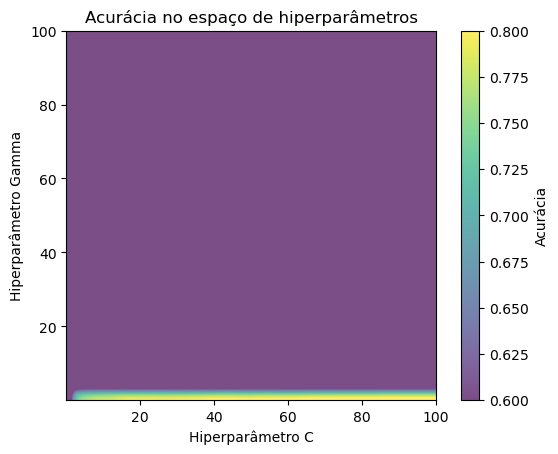

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# densidade_acuracia -> matriz de densidades 2D
# Aplicar suavização gaussiana para criar um efeito mais suave
sigma = 1  # Ajuste a suavidade
smoothed_density = gaussian_filter(densidade_acuracia.values, sigma=sigma)

# Usar 'imshow' com interpolação entre o espaço de hiperparâmetros que não percorremos
plt.imshow(
    smoothed_density,
    origin='lower',
    cmap='viridis',
    alpha=0.7,  # Transparência
    interpolation='gaussian',  # Interpolação suave
    extent=[0.01, 100, 0.01, 100],  # Limites do espaço vetorial dos hiperparametros,
    vmin = 0.6,
    vmax = 0.8
)

# Configurar rótulos dos eixos e título
plt.xlabel('Hiperparâmetro C')
plt.ylabel('Hiperparâmetro Gamma')
plt.title('Acurácia no espaço de hiperparâmetros')

# Adicionar uma barra de cor para referência visual
plt.colorbar(label='Acurácia')

# Exibir o mapa de calor
plt.show()

- Parametros com gamma < 1 otimizam mais a acurácia no modelo de SVM para esse problema

## Visualização da Simulação

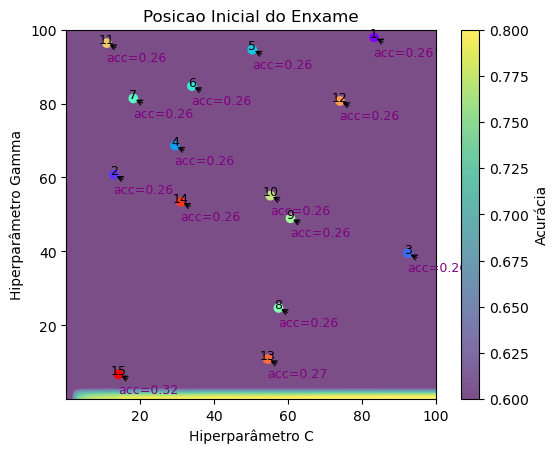

In [217]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


# Define o número de pontos
num_pontos = n_particles

# Cria as posições iniciais e finais para os pontos
x_inicial = df_pos_inicial['C'].values
y_inicial = df_pos_inicial['gamma'].values

x_final = df_pos_final['C'].values
y_final = df_pos_final['gamma'].values

# Define cores para cada ponto
colors = plt.cm.rainbow(np.linspace(0, 1, num_pontos))

# Gera valores aleatórios para as flechas
flechas_iniciais = df_pos_inicial.accuracy.values
flechas_finais = df_pos_final.accuracy.values

# Cria a figura e o eixo
fig, ax = plt.subplots()



######################## Part 1: Plota o espaço vetorial de hiperparametros e a acurácia

# densidade_acuracia -> matriz de densidades 2D
# Aplicar suavização gaussiana para criar um efeito mais suave
sigma = 1  # Ajuste a suavidade
smoothed_density = gaussian_filter(densidade_acuracia.values, sigma=sigma)

# Usar 'imshow' com interpolação entre o espaço de hiperparâmetros que não percorremos
plt.imshow(
    smoothed_density,
    origin='lower',
    cmap='viridis',
    alpha=0.7,  # Transparência
    interpolation='gaussian',  # Interpolação suave
    extent=[0.01, 100, 0.01, 100],  # Limites do espaço vetorial dos hiperparametros,
    vmin = 0.6,
    vmax = 0.8
)

# Configurar rótulos dos eixos e título
plt.xlabel('Hiperparâmetro C')
plt.ylabel('Hiperparâmetro Gamma')
#plt.title('Simulação no espaço de hiperparâmetros')

# Adicionar uma barra de cor para referência visual
plt.colorbar(label='Acurácia')

######################## Fim Part 1




# Define os limites do gráfico para garantir que todos os pontos sejam visíveis
ax.set_xlim(0.01, 100)
ax.set_ylim(0.01, 100)

# Cria o scatter plot para a animação
scatter = ax.scatter(x_inicial, y_inicial, c=colors)

# Rótulos para cada ponto
labels = [ax.text(x, y, str(i + 1), fontsize=9, ha='center') for i, (x, y) in enumerate(zip(x_inicial, y_inicial))]

# Adiciona flechas para os pontos iniciais
flechas_iniciais_annot = [
    ax.annotate(
        f"acc={flechas_iniciais[i]:.2f}",
        xy=(x_inicial[i], y_inicial[i]),
        xytext=(x_inicial[i] - 0.1, y_inicial[i] - 5),  # Aproximação do texto para encurtar a flecha
        textcoords="data",
        arrowprops=dict(arrowstyle="->", color="black"),
        fontsize=9,
        color="purple",
    )
    for i in range(num_pontos)
]


# Número de quadros para a animação
num_frames = 100

# Função para atualizar a posição dos pontos e das anotações em cada quadro
def update(frame):

    
    # Interpolação linear entre posições iniciais e finais
    x_interpolated = x_inicial + frame * (x_final - x_inicial) / num_frames
    y_interpolated = y_inicial + frame * (y_final - y_inicial) / num_frames
    
    scatter.set_offsets(np.column_stack((x_interpolated, y_interpolated)))
    
    # Atualiza a posição dos rótulos
    for label, x, y in zip(labels, x_interpolated, y_interpolated):
        label.set_position((x, y))
    
    # Controla as flechas para mostrar apenas no início e no final
    if frame == 0:
        ax.set_title('Posicao Inicial do Enxame')
        for flecha in flechas_iniciais_annot:
            flecha.set_visible(True)
    elif frame == num_frames - 1:
        ax.set_title('Posicao Final - N_ITERACAO = 31')

        # No final, atualiza as flechas com valores de acuracia
        flechas_finais_annot = [
            ax.annotate(
                f"acc={flechas_finais[i]:.2f}",
                xy=(x_interpolated[i], y_interpolated[i]),
                xytext=(x_interpolated[i] - 0.1, y_interpolated[i] - 5),  # Menos cumprido
                textcoords="data",
                arrowprops=dict(arrowstyle="->", color="black"),
                fontsize=9,
                color="purple",
            )
            for i in range(num_pontos)
        ]
        return scatter, *labels, *flechas_finais_annot
    else:
        ax.set_title('')

        # No meio da animação, tornamos as flechas invisíveis
        for flecha in flechas_iniciais_annot:
            flecha.set_visible(False)
    
    return scatter, *labels

# Cria a animação
anim = animation.FuncAnimation(
    fig, update, frames=num_frames, blit=True, interval=50, repeat=False
)

# Exibe a animação
plt.show()

In [218]:
anim.save("./images/animação.gif", writer="imagemagick")

2024-04-28 21:54:15,645 - matplotlib.animation - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2024-04-28 21:54:15,645 - matplotlib.animation - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


# Avaliação hiperparametros em dados de teste
- Vamos avaliar se o mínimo encontrado por PSO não overfitou!

In [213]:
X_test.head()

,COMPACTNESS,CIRCULARITY,DISTANCE_CIRCULARITY,RADIUS_RATIO,PR.AXIS_ASPECT_RATIO,MAX.LENGTH_ASPECT_RATIO,SCATTER_RATIO,ELONGATEDNESS,PR.AXIS_RECTANGULARITY,MAX.LENGTH_RECTANGULARITY,SCALED_VARIANCE_MAJOR,SCALED_VARIANCE_MINOR,SCALED_RADIUS_OF_GYRATION,SKEWNESS_ABOUT_MAJOR,SKEWNESS_ABOUT_MINOR,KURTOSIS_ABOUT_MAJOR,KURTOSIS_ABOUT_MINOR,HOLLOWS_RATIO
217,104.0,57.0,103.0,216.0,69.0,11.0,219.0,30.0,25.0,176.0,228.0,708.0,219.0,73.0,4.0,3.0,186.0,196.0
419,93.0,34.0,72.0,144.0,56.0,6.0,133.0,50.0,18.0,123.0,158.0,263.0,125.0,63.0,5.0,20.0,200.0,206.0
16,89.0,36.0,51.0,109.0,52.0,6.0,118.0,57.0,17.0,129.0,137.0,206.0,125.0,80.0,2.0,14.0,181.0,185.0
43,93.0,37.0,76.0,183.0,63.0,8.0,164.0,40.0,20.0,134.0,191.0,405.0,139.0,67.0,4.0,7.0,192.0,197.0
539,109.0,55.0,96.0,191.0,57.0,6.0,241.0,28.0,26.0,170.0,267.0,857.0,242.0,85.0,8.0,9.0,184.0,184.0


In [214]:
model = SVC(random_state=seed)
model.set_params(**{'C': melhor_C, 'gamma': melhor_gamma})

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])


In [215]:
from sklearn.metrics import accuracy_score
pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)
accuracy_score(y_test, y_pred)

0.8208092485549133

- Performance em dados de treino de 82.1% semelhante aos observados nos dados de teste 81.4%!

# Conclusões

- A exploração do enxame foi capaz de encontrar os melhores hiperparâmetros para um modelo de SVM, que performaram 81.4% de acurácia em dados de treino e 82.1% em dados de teste
- Não houve overfit
- PSO convergiu para melhor solução na sua 31ª iteração todas as iterações posteriores foram de exploração do espaço limitado pelas condições definidas do vetor de velocidade - fator de inercia, fator cognitivo e social